### Correlation between spins at specific points for TFIM + Sx

We already have proved that for an integrable system like TFIM if an additional Sx longitudinal field applied, the integrability breaks and we can observe thermal-localized phase crossover/transition. This happens when we operte at higher root of Bessel function.


In the code below, we have applied TFIM + Sx at 10th root of the Bessel function i.e. ~32.

In [3]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm


##-- Drive-------------------------------------------------
from scipy.sparse import dia_matrix

def get_jmat_pbc(lsize, beta):
    N = lsize
    J = dia_matrix((N, N))
    mid_diag = np.floor(N/2).astype(int)
    for i in np.arange(1,mid_diag+1):
        elem = pow(i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    for i in np.arange(mid_diag+1, N):
        elem = pow(N-i, -beta)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    return J.toarray()

def drive(t, args):
    h = args['h']
    w = args['w']
    return  h * np.cos(w * t)

def get_hamiltonian(N,beta):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H21, H22, H23=  empt, empt, empt
    
    
    jmat = get_jmat_pbc(N, beta)
    ##-- Hamiltonian ---------------------------------------

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sx, tensor(id1,tensor(sx,id2)))).full()) * jmat[i,j]
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H23 = H23 + Qobj(tensor(id,tensor(sx,id1)).full()) 
    
    return 0.5*H21, 0.5*H22, 0.5*H23

##-- Dynamics

def run_dynm_corr_avg(args):
    N=args['N']
    beta , sz_cor = args['beta'], args['sz_cor']   
    times = args['times']
    H21, H22, H23 =  get_hamiltonian(N,beta)
    
    params = args
    H = [H21,[H22,drive], H23]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_cor], args = params)
    return np.average(out.expect)

In [46]:
%%time
import h5py

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (7.5,6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})


Ns = [6]
ws = np.linspace(0.3, 50, 64)
beta = float('inf')
sx,sy,sz = sigmax(), sigmay(), sigmaz()

periods = 30
optss = [1e5]

for i, N in tqdm(enumerate(Ns)):
    print('Running for N-',N)
    nprocs = 4
    
    pos1 = 0
    pos2 = int(N/2)-1
    p = Pool(processes = nprocs) 
    opts = Options(nsteps=optss[i], num_cpus=1, openmp_threads=1)

    i,j = pos1, pos2
    id = qeye(2**i)
    dim11 = j-i-1
    id1 = qeye(2**dim11)
    dim12 = N-1-j
    id2 = qeye(2**dim12)
    sz_cor = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

    param = [{'h0':0, 'h':jn_zeros(0,10)[9] * w/2, 'N':N,'opts':opts, 'sz_cor':sz_cor,'w':w,\
               'beta':beta,'times':np.linspace(0, periods * 2*np.pi/w, 100, endpoint=False)} for w in ws]

    datas = np.array(p.map(run_dynm_corr_avg,param))
    
    fname = "sz"+str(pos1)+"sz"+str(pos1)+"N_"+ str(N)+"_.hdf5"

    with h5py.File(fname, 'w') as hf:
        hf.create_dataset('szsz', np.shape(datas), data=datas)
        hf.create_dataset('ws', np.shape(ws), data=ws)
        hf.attrs['N'] = N  
        hf.attrs['pos1'] = pos1
        hf.attrs['pos2'] = pos2
        hf.attrs['beta'] = beta

0it [00:00, ?it/s]

Running for N- 6


1it [00:05,  5.95s/it]

CPU times: user 28.9 ms, sys: 49 ms, total: 77.8 ms
Wall time: 5.96 s


In [2]:
!ls sz0*>szsz_phase_crossover_files.txt

In [4]:
cat szsz_phase_crossover_files.txt

sz0sz0N_8_.hdf5
sz0sz0N_10_.hdf5
sz0sz0N_12_.hdf5


3


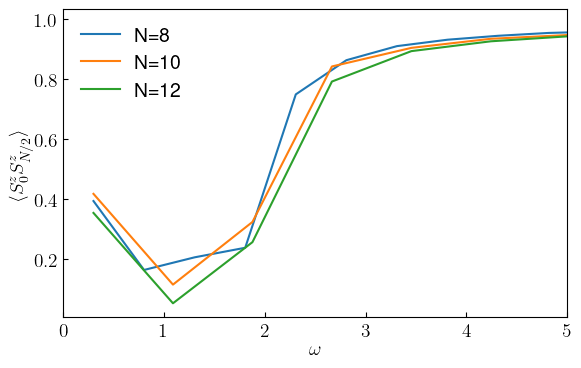

In [5]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

plt.rcParams.update({"figure.figsize": (6.5, 4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 14,"font.sans-serif": ["Helvetica"]})


with open("szsz_phase_crossover_files.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    print(x)
    for i in range(0,x):
        filename = lines[i][:-1]
        with h5py.File(filename, "r") as f:
            data = f['szsz'][()]
            ws = f['ws'][()]
            N = f.attrs['N']
            pos1 = f.attrs['pos1']
            pos2 = f.attrs['pos2']
            beta = f.attrs['beta']
            
            plt.plot(ws, data, label = fr"N={N}")
    
plt.ylabel(r"$ \langle S^z_0 S^z_{N/2}\rangle$", labelpad=0)
plt.xlabel(r"$\omega$", labelpad=0)
plt.tick_params(which='both', axis="x", direction="in")
plt.tick_params(which='both', axis="y", direction="in")
plt.xlim(0,5)
#plt.ylim(.97,1)
plt.legend(frameon=False)
plt.show()

### S-curve fit and $\omega_c$ variations

In [23]:
!ls sz0*>szsz_phase_crossover_files.txt

In [6]:
cat szsz_phase_crossover_files.txt

sz0sz0N_8_.hdf5
sz0sz0N_10_.hdf5
sz0sz0N_12_.hdf5


array([0.98176081, 1.97159812, 1.87342877])

array([0.9792066 , 2.05047438, 1.94243479])

array([0.97663218, 2.20609352, 2.52514353])

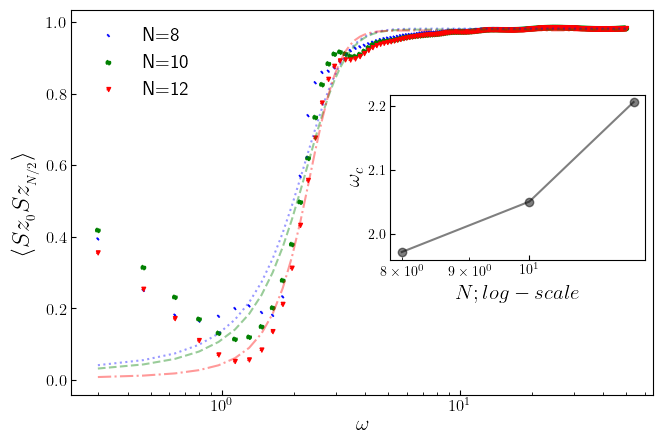

CPU times: user 2.3 s, sys: 191 ms, total: 2.49 s
Wall time: 1.36 s


In [19]:
%%time
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.optimize import curve_fit

def logistic(x, L=1, x_0=0, k=1):
    return L / (1 + np.exp(-k * (x - x_0)))

plt.rcParams.update({ "figure.figsize": (7.5, 5),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12, "font.sans-serif": ["Computer Modern"]})

ww, iprmm, NN = [], [], []
fig, ax1 = plt.subplots()
left, bottom, width, height = [0.55, 0.38, 0.34, 0.33]
ax3 = fig.add_axes([left, bottom, width, height])


fig.subplots_adjust(wspace=None, hspace=0.17)


k,x00, ns = [], [], []
with open("szsz_phase_crossover_files.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    
    linest = ['dotted', 'dashed', 'dashdot','solid']
    colors = ['blue', 'green', 'red','indigo']
    markers = ['.','o','v','s']
    for i in range(0,x):
        filename = lines[i][:-1]
        with h5py.File(filename, 'r') as f:    
            data = f['szsz'][()]
            ws = f['ws'][()]
            N = f.attrs['N']
            pos1 = f.attrs['pos1']
            pos2 = f.attrs['pos2']
            beta = f.attrs['beta']
            
            lbl = 'N=' + str(N)
            xnew = np.linspace(ws.min(), ws.max(), 300)
            ynew = make_interp_spline(ws, data, k = 3)
    
            #ax1.plot(xnew, ynew(xnew), label = lbl, linestyle= linest[i], color=colors[i])
            ax1.scatter(xnew, ynew(xnew), label = lbl, linestyle= linest[i],\
                        color=colors[i], marker=markers[i], s=10)
            ax1.set_xscale('log')
            #ax1.set_xlim(1,100)
            #ax1.set_ylim(-.1,1.100)
            ax1.set_xlabel(r"$\omega$", fontsize = 15, labelpad=1)
            ax1.set_ylabel(r"$\langle Sz_{_{0}}Sz_{_{N/2}}\rangle$", fontsize = 18, labelpad=5)
            ax1.tick_params(which='both', axis="x", direction="in")
            ax1.tick_params(which='both', axis="y", direction="in")
            ax1.legend(frameon = False, fontsize = 14, ncol=1, loc=2)  
            
            # S- Curve Fit
            #
            x,y = xnew, ynew(xnew)
            L_estimate = y.max()
            x_0_estimate = np.median(x)
            k_estimate = 1.0
            p_0 = [L_estimate, x_0_estimate, k_estimate]
            popt, pcov = curve_fit(logistic, x, y, p_0, method='dogbox')
            display(popt)
            k.append(popt[-1])
            x00.append(popt[1])
            ns.append(N)
            ax1.plot(x, logistic(x, *popt), linestyle=linest[i], color=colors[i],alpha = 0.4)
            
#ax3.plot(x, np.sin(x))
ax3.tick_params(which='both', axis="x", direction="in", labelsize=10)
ax3.tick_params(which='both', axis="y", direction="in", labelsize=10)
ax3.set_xlabel(r"$N; log-scale$", fontsize = 15, labelpad=5)
ax3.set_ylabel(r"$\omega_c$", fontsize = 15, labelpad=3)
#ax3.plot(ns, x00, color='black', linestyle = 'dashdot')
ax3.plot(ns, x00, marker = 'o',color='black', alpha = 0.5)
ax3.set_xticks([6.0,8.0,10.0,12.0])
ax3.set_xscale('log')

            


plt.savefig("szsz_phase_crossover_LMG.jpeg", bbox_inches='tight', pad_inches=0.0, dpi = 600)
plt.savefig("szsz_phase_crossover_LMG.svg", bbox_inches='tight', pad_inches=0.0, dpi = 300)


plt.show()